<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-Description" data-toc-modified-id="Project-Description-1">Project Description</a></span></li><li><span><a href="#Step-1.-Parsing-the-data-on-weather-in-Chicago" data-toc-modified-id="Step-1.-Parsing-the-data-on-weather-in-Chicago-2">Step 1. Parsing the data on weather in Chicago</a></span></li><li><span><a href="#Step-2.-Exploratory-data-analysis-with-SQL" data-toc-modified-id="Step-2.-Exploratory-data-analysis-with-SQL-3">Step 2. Exploratory data analysis with SQL</a></span></li><li><span><a href="#Step-3.-Exploratory-data-analysis-with-Python" data-toc-modified-id="Step-3.-Exploratory-data-analysis-with-Python-4">Step 3. Exploratory data analysis with Python</a></span><ul class="toc-item"><li><span><a href="#3.1-Trips-amount" data-toc-modified-id="3.1-Trips-amount-4.1">3.1 Trips amount</a></span></li><li><span><a href="#3.2--Novemver-drop-off-locations" data-toc-modified-id="3.2--Novemver-drop-off-locations-4.2">3.2  Novemver drop off locations</a></span></li></ul></li><li><span><a href="#Step-4.-Testing-Hypotheses" data-toc-modified-id="Step-4.-Testing-Hypotheses-5">Step 4. Testing Hypotheses</a></span><ul class="toc-item"><li><span><a href="#4.1-Formulating-Hypothesis" data-toc-modified-id="4.1-Formulating-Hypothesis-5.1">4.1 Formulating Hypothesis</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# Project Description

Zuber is a new ride-sharing company that's launching in Chicago.<br>
<b>The task</b> is to find patterns in the available information to understand passenger preferences and the impact of external factors on rides. To complete the task we will study a database, analyze data from competitors, and test a hypothesis about the impact of weather on ride frequency.<br>

<b>Description of the data</b><br>
A database with info on taxi rides in Chicago:<br>

<b>neighborhoods</b>** table: data on city neighborhoods<br>
<i>name</i>: name of the neighborhood<br>
<i>neighborhood_id</i>: neighborhood code<br>

**cabs table**: data on taxis<br>
<i>cab_id</i>: vehicle code<br>
<i>vehicle_id</i>: the vehicle's technical ID<br>
<i>company_name</i>: the company that owns the vehicle<br>

**trips table**: data on rides<br>
<i>trip_id</i>: ride code<br>
<i>cab_id</i>: code of the vehicle operating the ride<br>
<i>start_ts</i>: date and time of the beginning of the ride (time rounded to the hour)<br>
<i>end_ts</i>: date and time of the end of the ride (time rounded to the hour)<br>
<i>duration_seconds</i>: ride duration in seconds<br>
<i>distance_miles</i>: ride distance in miles<br>
<i>pickup_location_id</i>: pickup neighborhood code<br>
<i>dropoff_location_id</i>: dropoff neighborhood code<br>

**weather_records table**: data on weather<br>
<i>record_id</i>: weather record code<br>
<i>ts</i>: record date and time (time rounded to the hour)<br>
<i>temperature</i>: temperature when the record was taken<br>
<i>description</i>: brief description of weather conditions, e.g. "light rain" or "scattered clouds"<br>

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.display import Image

# Step 1. Parsing the data on weather in Chicago

We will write a code to parse the data on weather in Chicago in November 2017 from the website:
http://slava-public-access.s3-website-eu-west-1.amazonaws.com

In [2]:
URL = 'http://slava-public-access.s3-website-eu-west-1.amazonaws.com'
# Saving response object as req variable
req = requests.get(URL)
# Turning the an HTML file into a tree structure
soup = BeautifulSoup(req.text, 'lxml')
# Extracting table contents 
table = soup.find('table', attrs={"id": "weather_records"})

# Creating an empty list to store table headers
heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)

# Creating an empty list to store the table's rows
content = []   
for row in table.find_all('tr'):
    # Checking if the row is not headers
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

# Creating a data frame        
weather_records = pd.DataFrame(content, columns=heading_table)

In [3]:
weather_records

,Date and time,Temperature,Description
0,2017-11-01 00:00:00,276.150,broken clouds
1,2017-11-01 01:00:00,275.700,scattered clouds
2,2017-11-01 02:00:00,275.610,overcast clouds
3,2017-11-01 03:00:00,275.350,broken clouds
4,2017-11-01 04:00:00,275.240,broken clouds
...,...,...,...
692,2017-11-29 20:00:00,281.340,few clouds
693,2017-11-29 21:00:00,281.690,sky is clear
694,2017-11-29 22:00:00,281.070,few clouds
695,2017-11-29 23:00:00,280.060,sky is clear


# Step 2. Exploratory data analysis with SQL

This step will be performed with SQL queries. We are given four tables: neighborhoods, cabs, trips and weather_records. The relations between tables is depicted in the image below.<br>
Note: there isn't a direct connection between the tables trips and weather_records in the database. But we can still use JOIN and link them using the time the ride started (trips.start_ts) and the time the weather record was taken (weather_records.ts).

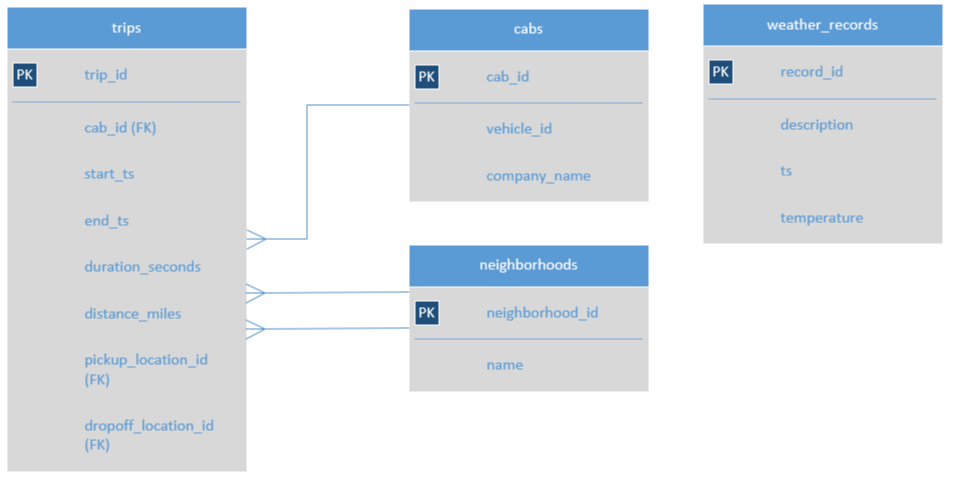

In [4]:
Image(filename="SQL_project_info/Relations_table.png")

##### 2.1 
<br>
Find the number of taxi rides for each taxi company for November 15-16, 2017. Name the resulting field trips_amount and print it along with the company_name field. Sort the results by the trips_amount field in descending order.

``` SQL
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    trips
INNER JOIN cabs ON cabs.cab_id = trips.cab_id    
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-15 00:00:00' AND '2017-11-16 00:00:00'
GROUP BY 
    company_name
ORDER BY 
    trips_amount DESC;
```

The result of the query is saved to the 'project_sql_result_01.csv' file ant the image below displays several rows of it. 

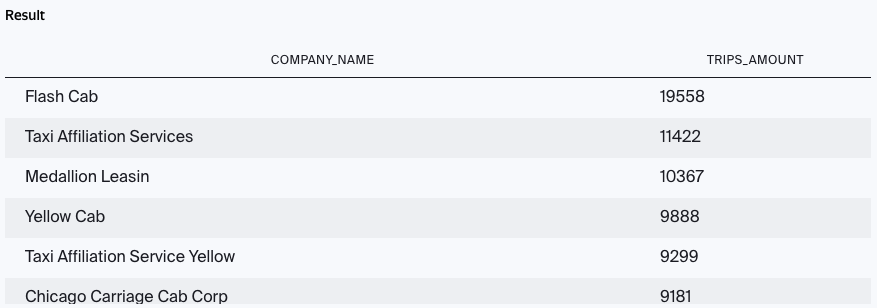

In [5]:
Image(filename="SQL_project_info/trips_amount.png")

##### 2.2 
<br>
Find the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017. Name the resulting variable trips_amount. Group the results by the company_name field.

``` SQL
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM trips
INNER JOIN cabs ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01 00:00:00' AND '2017-11-07 00:00:00'
    AND cabs.company_name LIKE '%Yellow%'
GROUP BY company_name
UNION
SELECT
    cabs.company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM trips
INNER JOIN cabs ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01 00:00:00' AND '2017-11-07 00:00:00'
    AND cabs.company_name LIKE '%Blue%'
GROUP BY company_name;
```

The result of the query is saved to the 'project_sql_result_02.csv' file ant the image below displays several rows of it. 

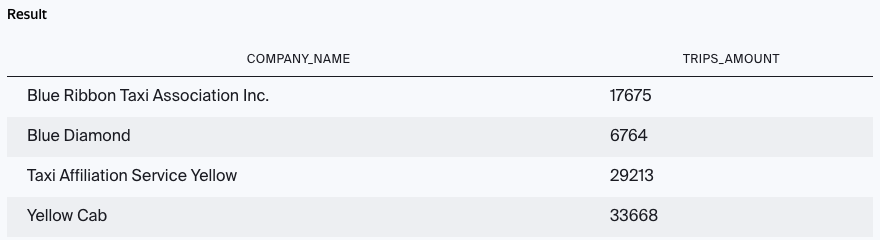

In [6]:
Image(filename="SQL_project_info/result_2.png")

##### 2.3 
<br>
For November 1-7, 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services. Find the number of rides for these two companies and name the resulting variable trips_amount. Join the rides for all other companies in the group "Other." Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by trips_amount.

``` SQL
SELECT
    CASE 
        WHEN cabs.company_name = 'Flash Cab' THEN 'Flash Cab'
        WHEN cabs.company_name = 'Taxi Affiliation Services' THEN 'Taxi Affiliation Services' 
        ELSE 'Other'
    END AS company,
    COUNT(trips.trip_id) AS trips_amount
FROM 
    trips
INNER JOIN 
    cabs 
ON 
    cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) BETWEEN '2017-11-01' AND '2017-11-07'
GROUP BY 
    company
ORDER BY
    trips_amount DESC;
```

The result of the query is saved to the 'project_sql_result_03.csv' file ant the image below displays several rows of it. 

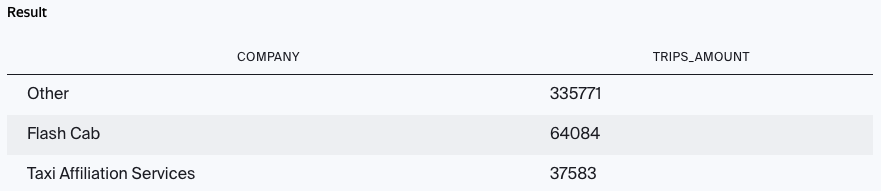

In [7]:
Image(filename="SQL_project_info/result_3.png")

##### 2.4 
<br>
Retrieve the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.

``` SQL
SELECT
    neighborhood_id,
    name
FROM 
    neighborhoods
WHERE
    name LIKE '%Hare%' OR name LIKE 'Loop';
```

The result of the query is saved to the 'project_sql_result_05.csv' file ant the image below displays several rows of it. 

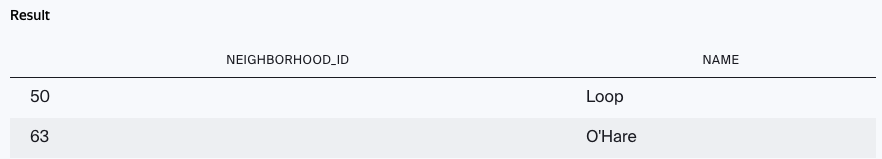

In [8]:
Image(filename="SQL_project_info/two_hoods_ids.png")

##### 2.5 
<br>
For each hour, retrieve the weather condition records from the weather_records table. Using the CASE operator, break all hours into two groups: Bad if the description field contains the words rain or storm, and Good for others. Name the resulting field weather_conditions. The final table must include two fields: date and hour (ts) and weather_conditions.

``` SQL
SELECT
    ts,
    CASE
        WHEN (description LIKE '%rain%' OR description LIKE '%storm%') THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions
FROM
    weather_records
```

The result of the query is saved to the 'project_sql_result_06.csv' file ant the image below displays several rows of it. 

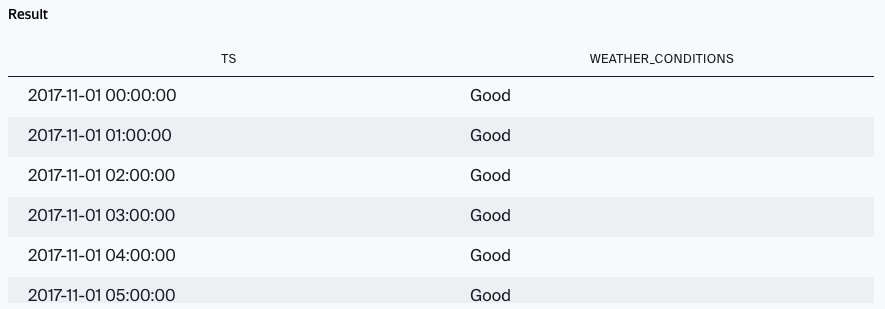

In [9]:
Image(filename="SQL_project_info/weather_condition_hourly.png")

##### 2.6 
<br>
Retrieve from the trips table all the rides that started in the Loop (neighborhood_id: 50) on a Saturday and ended at O'Hare (neighborhood_id: 63). Get the weather conditions for each ride. Use the method you applied in the previous task. Also retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available.
The table columns should be in the following order:
- start_ts
- weather_conditions
- duration_seconds
Sort by trip_id.

``` SQL
SELECT
    trips.start_ts,  
    CASE
        WHEN (description LIKE '%rain%' OR description LIKE '%storm%') THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions,
    trips.duration_seconds
FROM
    weather_records
INNER JOIN
    trips
ON
    trips.start_ts = weather_records.ts    
WHERE
    pickup_location_id = 50 AND dropoff_location_id = 63
    AND EXTRACT(DOW FROM trips.start_ts) = 6
ORDER BY
    trip_id ;
```

The result of the query is saved to the 'project_sql_result_07.csv' file ant the image below displays several rows of it. 

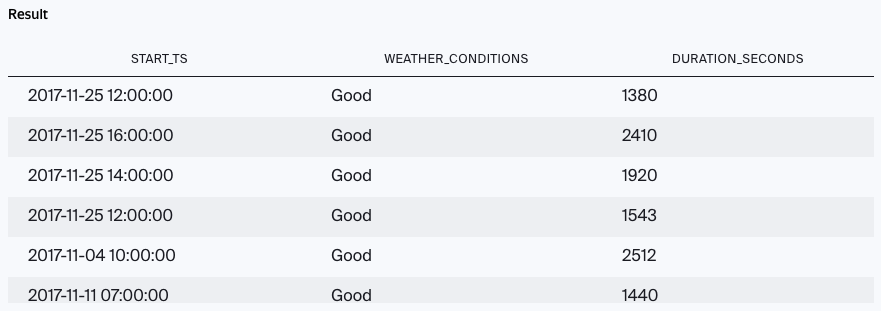

In [10]:
Image(filename="SQL_project_info/rides_to_airport.png")

# Step 3. Exploratory data analysis with Python

## 3.1 Trips amount

Our task is to open CSV file, which is a result of the SQL query performed previously. The file contains the following data:<br>
<b>company_name</b>: taxi company name<br>
<b>trips_amount</b>: the number of rides for each taxi company on November 15-16, 2017.

In [11]:
trips_amount = pd.read_csv('SQL_project_info/project_sql_result_01.csv')
trips_amount.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [12]:
trips_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [13]:
trips_amount.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


In [14]:
trips_amount.trips_amount.sum()

137311

The table has 64 rows - 64 independent taxi companies that operate in Chicago, IL. The total amount of trips made within two days is 137,311. The amount of trips performed by each company varies significantly from a minimum of 2 to a maximum of 19,558, which suggests that data is not distributed evenly. Let's dig dipper to see which companies are leading in taxi rides.

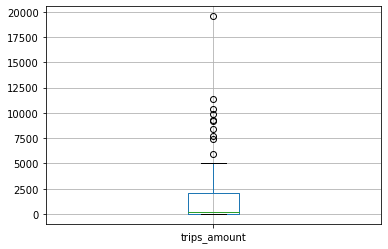

In [15]:
trips_amount.boxplot(column=['trips_amount']);

In [16]:
trips_amount['rides_from_total'] = trips_amount['trips_amount'] * 100 / trips_amount.trips_amount.sum()

In [17]:
trips_amount.head(6)

,company_name,trips_amount,rides_from_total
0,Flash Cab,19558,14.243578
1,Taxi Affiliation Services,11422,8.318343
2,Medallion Leasin,10367,7.550014
3,Yellow Cab,9888,7.201171
4,Taxi Affiliation Service Yellow,9299,6.772218
5,Chicago Carriage Cab Corp,9181,6.686282


Six top companies make about a half of all rides. The leader in passenger tixi transfer in Chicago is the Flash Cab company, which makes almost twice as much as its nearest rival. 

## 3.2  Novemver drop off locations

Our task is to open CSV file, which is a result of the SQL query performed previously. The file contains the following data:<br>
<b>dropoff_location_name</b>: Chicago neighborhoods where trips ended<br>
<b>average_trips</b>: the average number of rides that ended in each neighborhood in November 2017.

In [18]:
november_drop_off = pd.read_csv('SQL_project_info/project_sql_result_04.csv')
november_drop_off.head(5)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [19]:
november_drop_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


Let's change data type for the average trips values from float to int.

In [20]:
november_drop_off.average_trips = november_drop_off.average_trips.astype('int')

In [21]:
november_drop_off.describe()

,average_trips
count,94.000000
mean,599.478723
std,1714.555974
min,1.000000
25%,14.000000
50%,51.500000
75%,298.750000
max,10727.000000


There are 94 unique destination locations for the taxi rides that were made in Chicago in November 2017. One location was only visited ones, whereas the most popular was visited 10,727 times. The average number of times for a location to be a taxi ride drop-off point is 599, although the median is 51, which suggests that the popularity of locations is not even and that the distribution is probably skewed to the right.

In [22]:
top_ten_locations = november_drop_off.sort_values(by=['average_trips'], ascending=False)[:10]

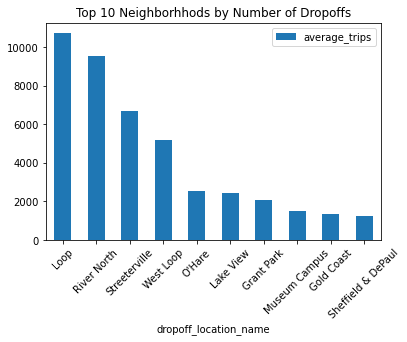

In [23]:
top_ten_locations.plot(kind='bar', x='dropoff_location_name', y='average_trips', rot=45)
plt.title('Top 10 Neighborhhods by Number of Dropoffs');

The most popular location is the Loop, which is probably a city center area with a lot of attractions, restaurants, bars, etc.

# Step 4. Testing Hypotheses

The task is to open a CSV file, which is a result of a SQL query performed earlier. The file contains data on rides from the Loop to O'Hare International Airport. These are the table's field values:<br>
<b>start_ts</b> - pickup date and time<br>
<b>weather_conditions</b> - weather condition at the moment the ride started<br>
<b>duration_seconds</b> - ride duration is seconds

In [24]:
rides_to_airport = pd.read_csv('SQL_project_info/project_sql_result_07.csv')
rides_to_airport.head(5)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [25]:
rides_to_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [26]:
rides_to_airport.shape

(1068, 3)

Let's change data type for the start_ts column to date type and for the duration_seconds to the int type.

In [27]:
rides_to_airport.start_ts = pd.to_datetime(rides_to_airport.start_ts, format='%Y-%m-%d %H:%M:%S')

In [28]:
rides_to_airport.duration_seconds = rides_to_airport.duration_seconds.astype('int')

In [29]:
rides_to_airport.duration_seconds.describe()

count    1068.000000
mean     2071.731273
std       769.461125
min         0.000000
25%      1438.250000
50%      1980.000000
75%      2580.000000
max      7440.000000
Name: duration_seconds, dtype: float64

Minimum duration of a ride is 0 seconds, which doesn't make much sense. Let's look at how many there are rides that lasted less than 5 mins.

In [30]:
rides_to_airport.query('duration_seconds < 5*60')

,start_ts,weather_conditions,duration_seconds
15,2017-11-25 13:00:00,Good,60
163,2017-11-11 09:00:00,Good,0
168,2017-11-11 07:00:00,Good,0
204,2017-11-18 19:00:00,Good,0
552,2017-11-04 01:00:00,Good,0
801,2017-11-04 09:00:00,Good,0
1063,2017-11-25 11:00:00,Good,0


It is only 7 rows out of a total 1068. It seems reasonable to remove them.

In [31]:
rides_to_airport = rides_to_airport.query('duration_seconds > 5*60')

In [32]:
rides_to_airport.groupby('weather_conditions').describe()

duration_seconds                                          \
                              count         mean         std    min     25%   
weather_conditions                                                            
Bad                           180.0  2427.205556  721.314138  480.0  1962.0   
Good                          881.0  2015.496027  741.064793  420.0  1404.0   

                                            
                       50%     75%     max  
weather_conditions                          
Bad                 2540.0  2928.0  4980.0  
Good                1800.0  2460.0  7440.0

The average duration of rides on a bad weather day seems to be longer than on a good weather day. Let's formulate and test hypotheses.

## 4.1 Formulating Hypothesis

The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.
Let's formulate the null and the alternative hypotheses.<br>
Ho : m1 = m2 (the mean trip duration on rainy Sundays is equal to the mean trip duration on sunny Sundays)<br>
Ha : m1 <> m2 (the mean trip duration on rainy Sundays is NOT equal to the mean trip duration on sunny Sundays)


In [33]:
# Setting the statistical significance level:
alpha = .05

In [34]:
rides_to_airport.query('weather_conditions == "Good"').duration_seconds.var()

549177.0275410176

In [35]:
rides_to_airport.query('weather_conditions == "Bad"').duration_seconds.var()

520294.08600248274

Two variances have about 5% difference, therefore we will assume that our two populations have the same variance. 

In [36]:
result = st.ttest_ind(rides_to_airport.query('weather_conditions == "Good"').duration_seconds, 
                      rides_to_airport.query('weather_conditions == "Bad"').duration_seconds, 
                      equal_var=True)

In [37]:
result

Ttest_indResult(statistic=-6.822448291178219, pvalue=1.5028117595948955e-11)

In [38]:
result.pvalue < alpha

True

<b>Conclusion</b>: The data provides enough evidence, given the significance level we selected, that we can reject the null hypothesis and therefore can conclude that the average trip duration on sunny and rainy Sundays are different.

# Conclusion

1. Chicago, IL weather information for November 2017 was retrieved from the online source.
2. A ride-sharing company - Zuber provided a database with info on taxi rides in Chicago, IL. The database had four tables: neighborhoods, cabs, trips and weather records. We explored data in the database with SQL queries and saved results of some queries in csv format.
3. Then we analyzed the results of SQL queries with Python and discovered that:<br>
There are 64 independent taxi transportation providers who operated on chosen days<br>
Majority of the trips were performed by the Flash Cab company (14.2% of total amount of trips for chosen period)<br>
Six top companies together make about 50% of total trips<br>
The most popular destinations for taxi rides are the Loop, The River North district and Streeterville.<br>
4. We performed statistical test to test the following hypothesis: the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays. The test results let us to reject the null hypothesis and, therefore, to concluded that weather affects the average trips amount.